In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, Flatten, GlobalAveragePooling2D, BatchNormalization, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

2025-06-15 02:11:30.976475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749953491.193263      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749953491.251872      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Visualising our data

In [ ]:
# Define a function to plot training history (accuracy and loss)
def plot_training_history(history, title_prefix="Model"):
    # Get accuracy and loss from history
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    epochs_range = range(len(acc))

    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title_prefix} Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title_prefix} Loss')

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

In [ ]:
# Define the path to the image dataset
image_path = "/kaggle/input/sneakers-classification/sneakers-dataset/sneakers-dataset"

# Load the training dataset from the directory
train_ds = image_dataset_from_directory(
    directory=image_path,
    validation_split=0.2, # Split 20% for validation
    subset='training', # Use as training set
    seed=42, # Set seed for reproducibility
    image_size=(224,224), # Resize images to 224x224
    shuffle=True, # Shuffle the data
    batch_size=32 # Set batch size
)

# Load the validation dataset from the directory
validation_ds = image_dataset_from_directory(
    directory=image_path,
    validation_split=0.2, # Split 20% for validation
    subset='validation', # Use as validation set
    seed=42, # Set seed for reproducibility
    image_size=(224,224), # Resize images to 224x224
    shuffle=True, # Shuffle the data
    batch_size=32 # Set batch size
)

Found 5953 files belonging to 50 classes.
Using 4763 files for training.


I0000 00:00:1749953507.768090      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 5953 files belonging to 50 classes.
Using 1190 files for validation.


In [ ]:
# Load the dataset statistics CSV file into a pandas DataFrame
df = pd.read_csv('/kaggle/input/sneakers-classification/dataset_stats.csv')

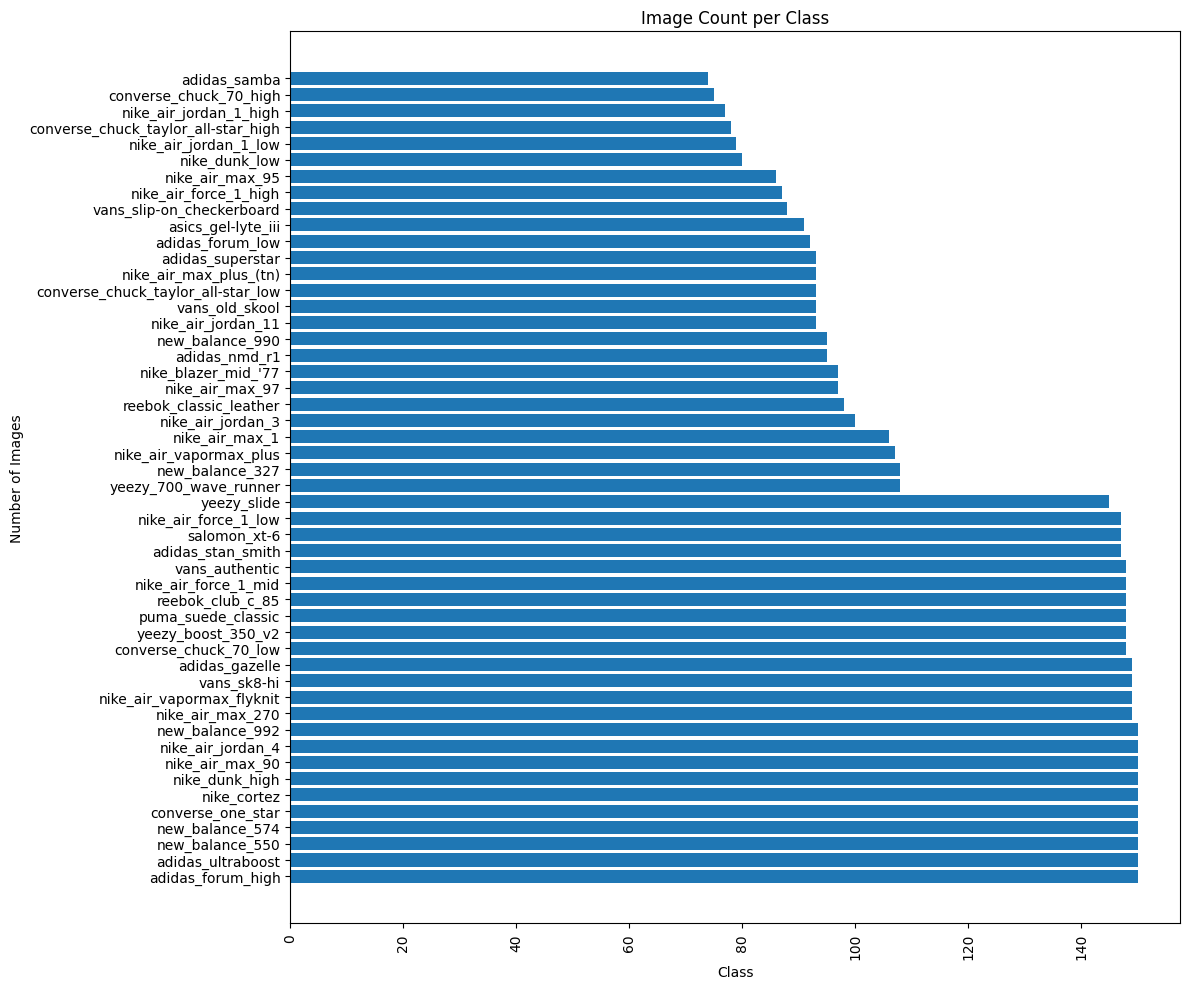

In [ ]:
# Create a horizontal bar chart to show image count per class
plt.figure(figsize=(12, 10))
plt.barh(df['class'], df['image_count'])
plt.xticks(rotation=90) # Rotate x-axis labels for readability
plt.title("Image Count per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout() # Adjust layout
plt.show() # Display the plot

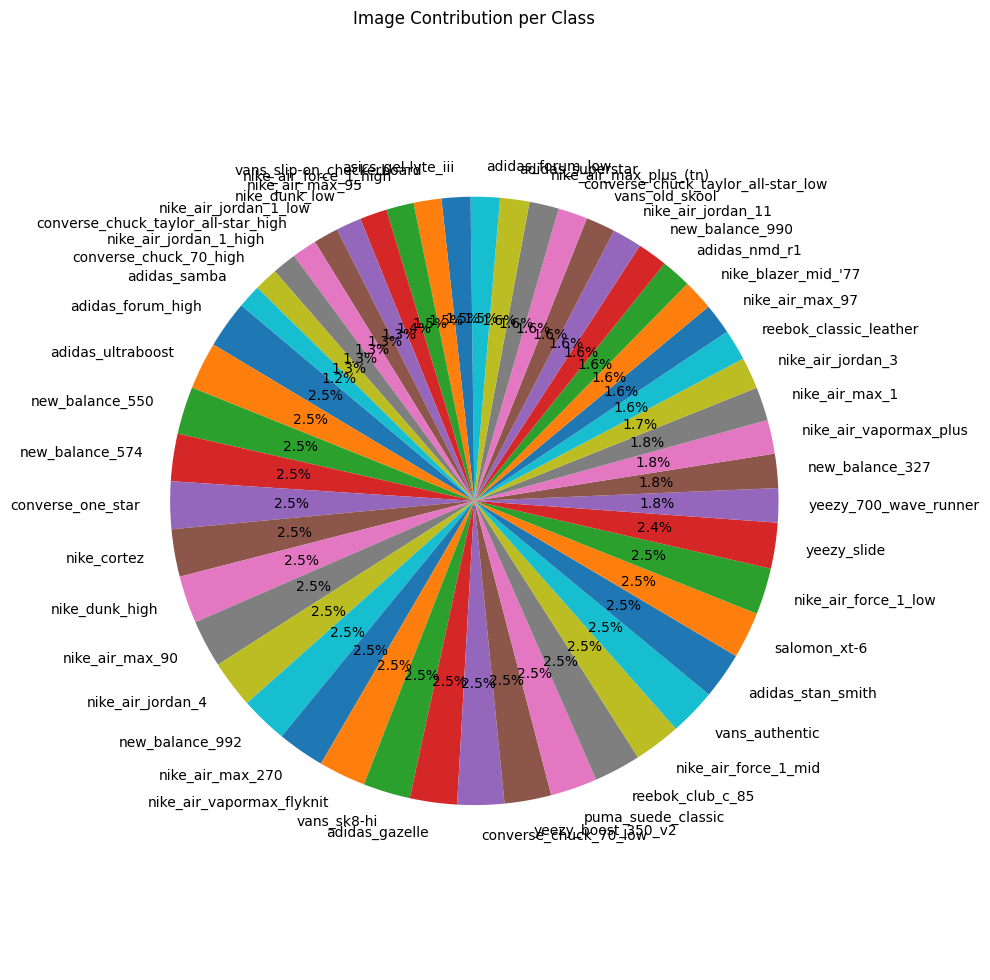

In [ ]:
# Create a pie chart to show image contribution per class
plt.figure(figsize=(10, 10))
plt.pie(df['image_count'], labels=df['class'], autopct='%1.1f%%', startangle=140)
plt.title("Image Contribution per Class")
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout() # Adjust layout
plt.show() # Display the plot

In [ ]:
# Take one batch from the training dataset and print the shape of images and labels
for images, labels in train_ds.take(1):
    print(f"labels size:{labels.shape}")
    print(f"Images size:{images.shape}")

labels size:(32,)
Images size:(32, 224, 224, 3)


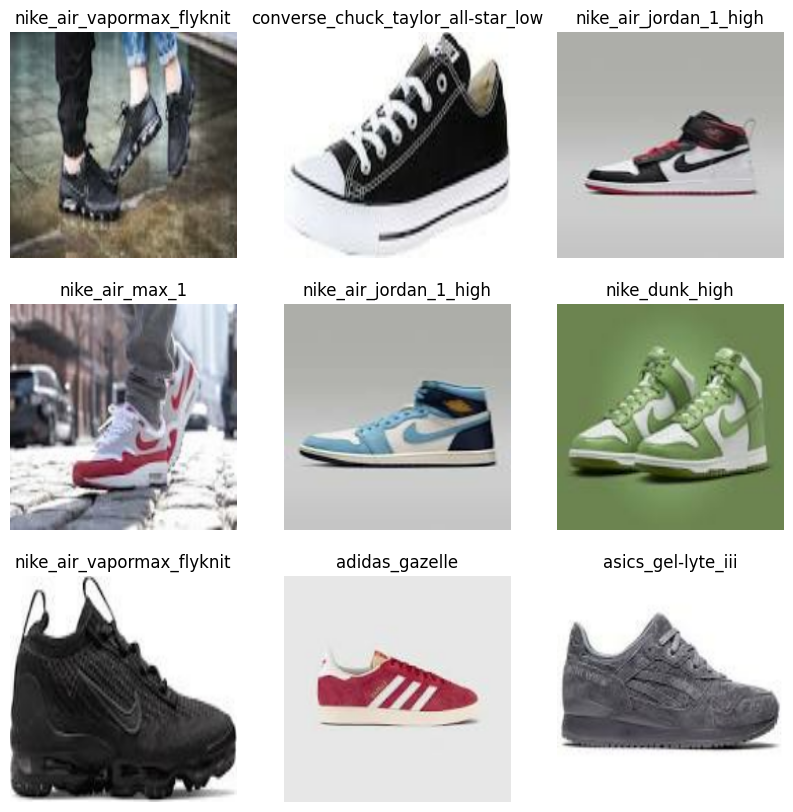

In [ ]:
# Get class names from the training dataset
class_names=train_ds.class_names

# Display 9 sample images from the training dataset with their class names
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off') # Turn off axes

# Creating Test data

In [ ]:
# Get the number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(validation_ds)

# Take half of the validation batches for the test set
test_ds = validation_ds.take(val_batches // 2)

# Skip the taken batches from the validation set
validation_ds = validation_ds.skip(val_batches // 2)

In [ ]:
# Print the number of batches in each dataset split
print(f"Number of train batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_ds)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_ds)}")

Number of train batches: 149
Number of validation batches: 19
Number of test batches: 19


# Configure the dataset

In [ ]:
# Define AUTOTUNE for optimizing data loading
AUTOTUNE = tf.data.AUTOTUNE

# Apply prefetch to datasets for performance improvement
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Print the dataset objects after applying prefetching
print(train_ds)
print(validation_ds)
print(test_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


# Use data augmentation

In [ ]:
# Define data augmentation layers as a Sequential model
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'), # Randomly flip images horizontally
    tf.keras.layers.RandomRotation(0.2), # Randomly rotate images by up to 20%
    tf.keras.layers.RandomZoom(0.2), # Randomly zoom in on images by up to 20%
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2) # Randomly translate images
])

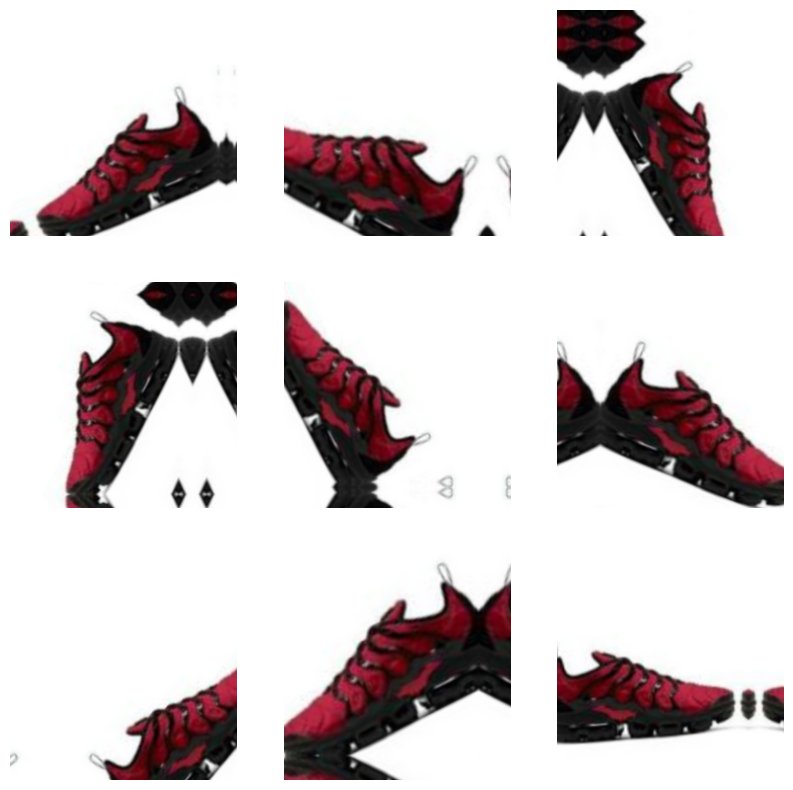

In [ ]:
# Demonstrate the effect of data augmentation on a sample image
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        # Apply data augmentation and display the augmented image
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# Creating the model using pretrained ResNet50

In [ ]:
# Load a pre-trained ResNet50 model
pretrained_model = tf.keras.applications.ResNet50(include_top=False, # Exclude the top classification layer
                                                  input_shape=(224, 224, 3), # Define input shape
                                                  weights='imagenet') # Load weights pre-trained on ImageNet

# Set the pre-trained model to be trainable
pretrained_model.trainable = True

# Freeze the first 10 layers of the pre-trained model
for layer in pretrained_model.layers[:10]:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Get a batch of images and labels from the training dataset
image_batch, label_batch = next(iter(train_ds))

# Pass the image batch through the pre-trained model to get features
feature_batch = pretrained_model(image_batch)

# Print the shape of the feature batch
print(feature_batch.shape)

I0000 00:00:1749953517.550661      19 cuda_dnn.cc:529] Loaded cuDNN version 90300


(32, 7, 7, 2048)


In [ ]:
# Print the summary of the pre-trained ResNet50 model
pretrained_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,520,704 (89.72 MB)

 Non-trainable params: 67,008 (261.75 KB)

In [ ]:
# Get the number of classes
classes_len = len(class_names)

# Define the input layer
inputs = tf.keras.Input(shape=(224,224,3))

# Apply data augmentation
x = data_augmentation(inputs)
# Apply ResNet50 preprocessing
x = tf.keras.layers.Lambda(preprocess_input)(x)
# Pass through the pre-trained ResNet50 model
x = pretrained_model(x)
# Apply Global Average Pooling
x = GlobalAveragePooling2D()(x)
# Apply Batch Normalization
x = BatchNormalization()(x)
# Add a dense layer with ReLU activation
x = Dense(32, activation='relu')(x)
# Add dropout for regularization
x = Dropout(0.5)(x)
# Add the output dense layer with L2 regularization
outputs = Dense(classes_len, kernel_regularizer=regularizers.l2(0.01))(x)

# Create the final model
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Print the summary of the complete model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          65,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           1,650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,663,122 (90.27 MB)

 Trainable params: 23,592,018 (90.00 MB)

 Non-trainable params: 71,104 (277.75 KB)

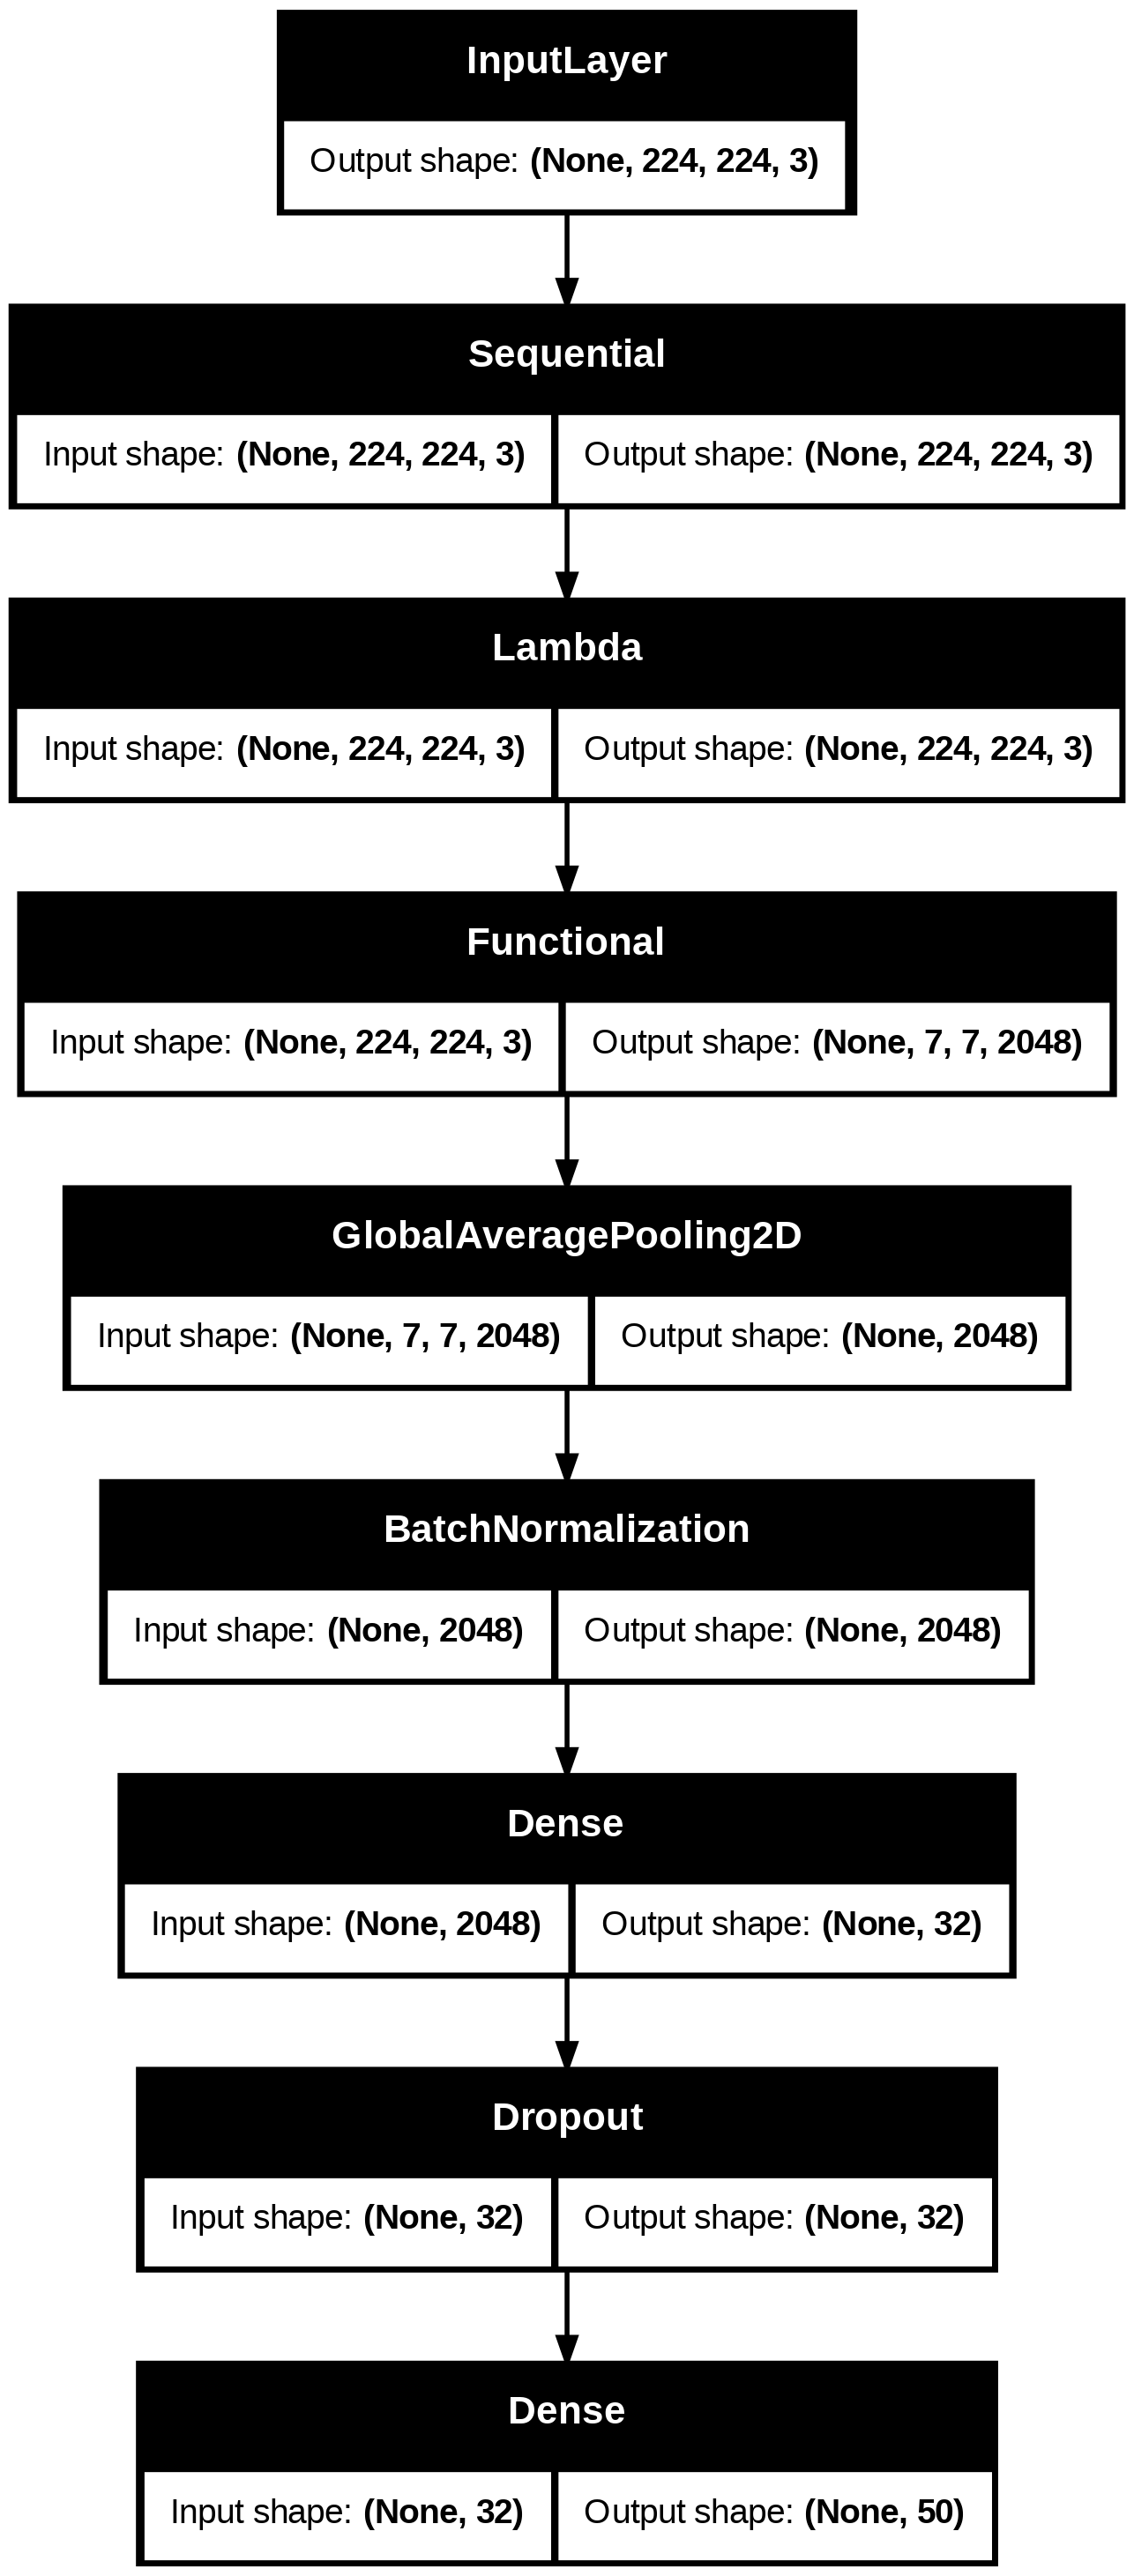

In [ ]:
# Plot the model architecture and display it
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Define the learning rate
learning_rate = 0.0001

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), # Use Adam optimizer with the specified learning rate
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # Use Sparse Categorical Crossentropy loss
              metrics=['accuracy']) # Monitor accuracy during training

In [ ]:
# Define callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss', # Monitor validation loss
        patience=7, # Stop training if validation loss doesn't improve for 7 epochs
        restore_best_weights=True, # Restore best weights found during training
    ),
    ModelCheckpoint(
        filepath='best_model.h5', # Filepath to save the best model
        save_best_only=True, # Save only the best model
        monitor='val_loss', # Monitor validation loss to determine the best model
    ),
    ReduceLROnPlateau(
        monitor='val_loss', # Monitor validation loss
        factor=0.5, # Reduce learning rate by a factor of 0.5
        patience=3, # Reduce learning rate if validation loss doesn't improve for 3 epochs
    )
]

In [ ]:
# Train the model
history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=100, # Train for a maximum of 100 epochs
                    callbacks=callbacks) # Use the defined callbacks

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 108s 357ms/step - accuracy: 0.0373 - loss: 4.6869 - val_accuracy: 0.1186 - val_loss: 4.1450 - learning_rate: 1.0000e-04
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 47s 315ms/step - accuracy: 0.1026 - loss: 4.0458 - val_accuracy: 0.2663 - val_loss: 3.4921 - learning_rate: 1.0000e-04
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 47s 316ms/step - accuracy: 0.1796 - loss: 3.6324 - val_accuracy: 0.3557 - val_loss: 3.0947 - learning_rate: 1.0000e-04
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 47s 316ms/step - accuracy: 0.2577 - loss: 3.2768 - val_accuracy: 0.4227 - val_loss: 2.8611 - learning_rate: 1.0000e-04
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 47s 316ms/step - accuracy: 0.3490 - loss: 2.9887 - val_accuracy: 0.4588 - val_loss: 2.6356 - learning_rate: 1.0000e-04
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 47s 316ms/step - accuracy: 0.3944 - loss: 2.6823 - val_accuracy: 0.5292 - val_loss: 2.3461 - learning_rate: 1.0000e-04
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━

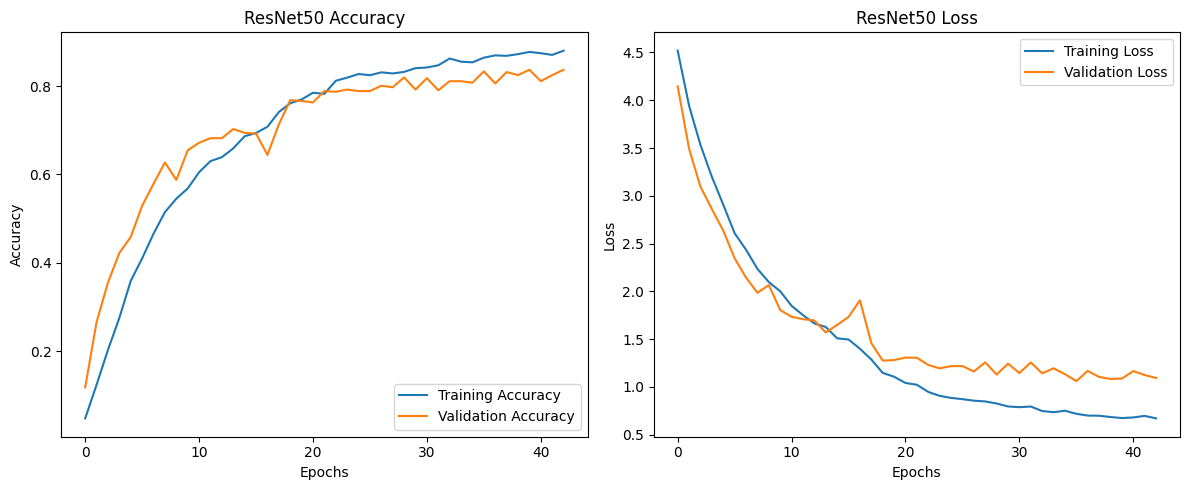

In [ ]:
# Plot the training history (accuracy and loss)
plot_training_history(history,'ResNet50')

# Evaluating our model

In [ ]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_ds)

# Print the test accuracy and loss
print('Test accuracy :', accuracy)
print('Test loss :', loss)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8549 - loss: 0.9005
Test accuracy : 0.8486841917037964
Test loss : 0.9415948987007141


In [ ]:
# Get a batch of images and labels from the test dataset
image_batch, label_batch = test_ds.as_numpy_iterator().next()

# Make predictions on the image batch
predictions = model.predict_on_batch(image_batch)

# Apply softmax to convert logits to probabilities
predictions = tf.nn.softmax(predictions)

# Get the predicted class index for each image
predictions = np.argmax(predictions, axis=1)

# Print the predicted class indices
predictions

array([39,  7, 16, 44, 27, 33, 16, 39, 25, 20, 18, 17, 18, 23,  4, 48, 24,
       20, 33, 34,  7, 24, 17, 19, 18, 31, 28, 22, 36, 48, 25,  5])

Predictions:
 [39  7 16 44 27 33 16 39 25 20 18 17 18 23  4 48 24 20 33 34  7 24 17 19
 18 31 28 22 36 48 25  5]
Labels:
 [ 1  7 16 44 27 33 16 39 25 19 18 16 18 13  4 48 24 20 33 34  7 24 17 19
 17 31 28 22 36 48 25  5]


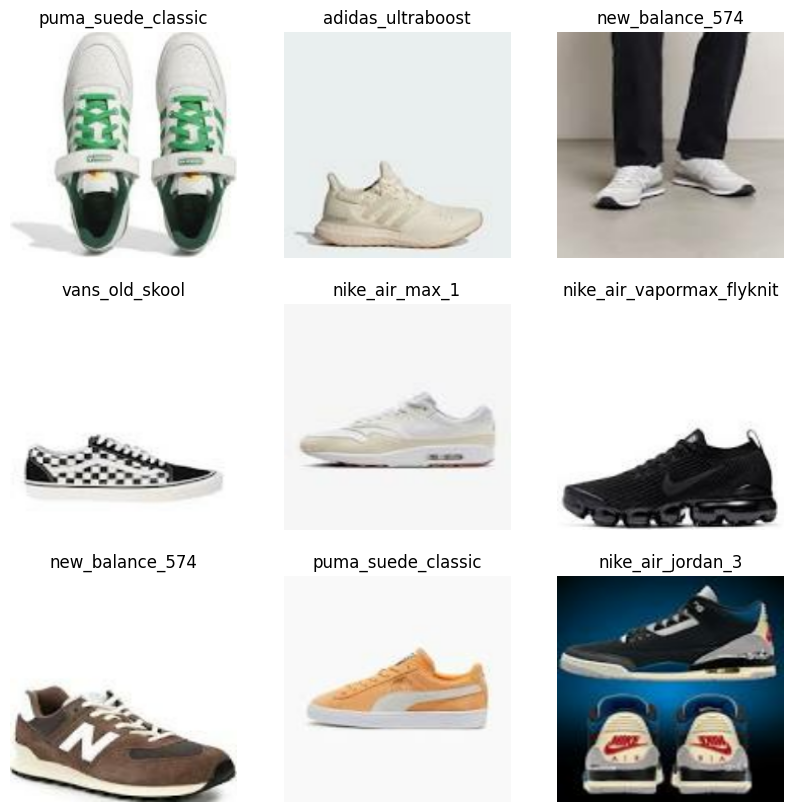

In [ ]:
# Print the predicted class indices and true labels
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

# Display 9 test images with their predicted class names
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Iterate over the test dataset
for images, labels in test_ds:
    # Make predictions for each batch
    batch_pred = model.predict(images)
    # Extend the predicted and true labels lists
    y_pred.extend(np.argmax(batch_pred, axis=1))
    y_true.extend(labels.numpy())

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
                                     precision    recall  f1-score   support

                  adidas_forum_high       0.77      0.91      0.83        11
                   adidas_forum_low       1.00      0.67      0.80         6
                     adidas_ga